In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score

In [ ]:
#Чтобы потом оценить как хорошо мы справляемся

def score_dataset(X, y, model=XGBRegressor(random_state=0)):
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error",
    ) #cv=5 - Берет модель, делит ее на 5 частей, одну часть берет в качестве y, остальные 4 в качсетве x, потом модель
    #учится на x, проверяется на y, итак делается 5 раз, т.е. 5 раз обучает, 5 раз проверяет
    #mean_absolute_error - среднее абсолютных разностей между целевыми значением и значением, предсказанным моделью 
    #neg что при максимазации функции ошибка не была бы больше 0 (больше 0 по умолчанию быть не может) (для удобства)    
    
    return -score.mean() #выводит среднее значение

In [19]:
df = pd.read_csv("D:/Python_Projects/PCA/Pizza.csv")
df.head()

,brand,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,A,14016,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,A,14005,30.49,21.28,41.65,4.82,1.64,1.76,4.67


In [20]:
df.describe()

,id,mois,prot,fat,ash,sodium,carb,cal
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,20841.040000,40.903067,13.373567,20.229533,2.633233,0.669400,22.864767,3.271000
std,6962.917222,9.552987,6.434392,8.975658,1.269724,0.370358,18.029722,0.620034
min,14003.000000,25.000000,6.980000,4.380000,1.170000,0.250000,0.510000,2.180000
25%,14093.750000,30.902500,8.060000,14.770000,1.450000,0.450000,3.467500,2.910000
50%,24020.500000,43.300000,10.440000,17.135000,2.225000,0.490000,23.245000,3.215000
75%,24110.250000,49.115000,20.022500,21.435000,3.592500,0.702500,41.337500,3.520000
max,34045.000000,57.220000,28.480000,47.200000,5.430000,1.790000,48.640000,5.080000


In [22]:
#Выбор фич для PCA
import pandas as pd

df = pd.read_csv("D:/Python_Projects/PCA/Pizza.csv")

df.corrwith(df.cal, numeric_only=True).sort_values() #выберем фичи которые хорошо коррелируют с cal

mois     -0.764441
carb     -0.023485
id       -0.021209
prot      0.070258
ash       0.326468
sodium    0.671958
fat       0.764567
cal       1.000000
dtype: float64

In [24]:
features = ["fat", "sodium", "ash"]

print("Correlation with cal")
print(df[features].corrwith(df.cal))

Correlation with cal
fat       0.764567
sodium    0.671958
ash       0.326468
dtype: float64


In [12]:
#PCA
#Используем PCA чтобы найти новые фичи, поэтому есть x и y в данном случае

from sklearn.decomposition import PCA #чтобы понять какие фичи можно сгенерирровать на основе того, что у нас есть

X = df.copy()
y = X.pop("cal")
X = X.loc[:, features] #Переносим в X только нужные фичи

# Стандартизация
X_stand = (X - X.mean(axis=0)) / X.std(axis=0)

pca = PCA() #будет искать коэффициенты для фичей и т.д. PCA()- () все компонеты которые подали будут на выходе
X_pca = pca.fit_transform(X_stand)

# Переводим результат в Pandas Dataframe чтобы удобнее было далее смотреть
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T, #pca.components - берем коэффициенты, которые будут стоять перед каждой фичей, чтобы преобразовать ее в 
    #новое линейное пространтсво
    columns=component_names,
    index=X.columns,
)

print(loadings)
#PC1, PC2, PC3 - коэффициенты, показывающие на что нужно перемножить соответственно fat, sodium, ash чтобы перенести
#их в новое пространство, знак "-" обратная зависимость
#PC3 - фича, где много sodium, и мало fat

#Интерпретация и оценка

X = df[features].copy()
y = df.cal.copy()

X = X.join(X_pca.PC3)
X['New feature'] = X.sodium / X.fat

score = score_dataset(X, y)
print(score) #это число должно быть минимальным

             PC1       PC2       PC3
fat     0.585903 -0.431446 -0.685982
sodium  0.589399 -0.354083  0.726109
ash     0.556171  0.829747 -0.046835
0.2781250951766968


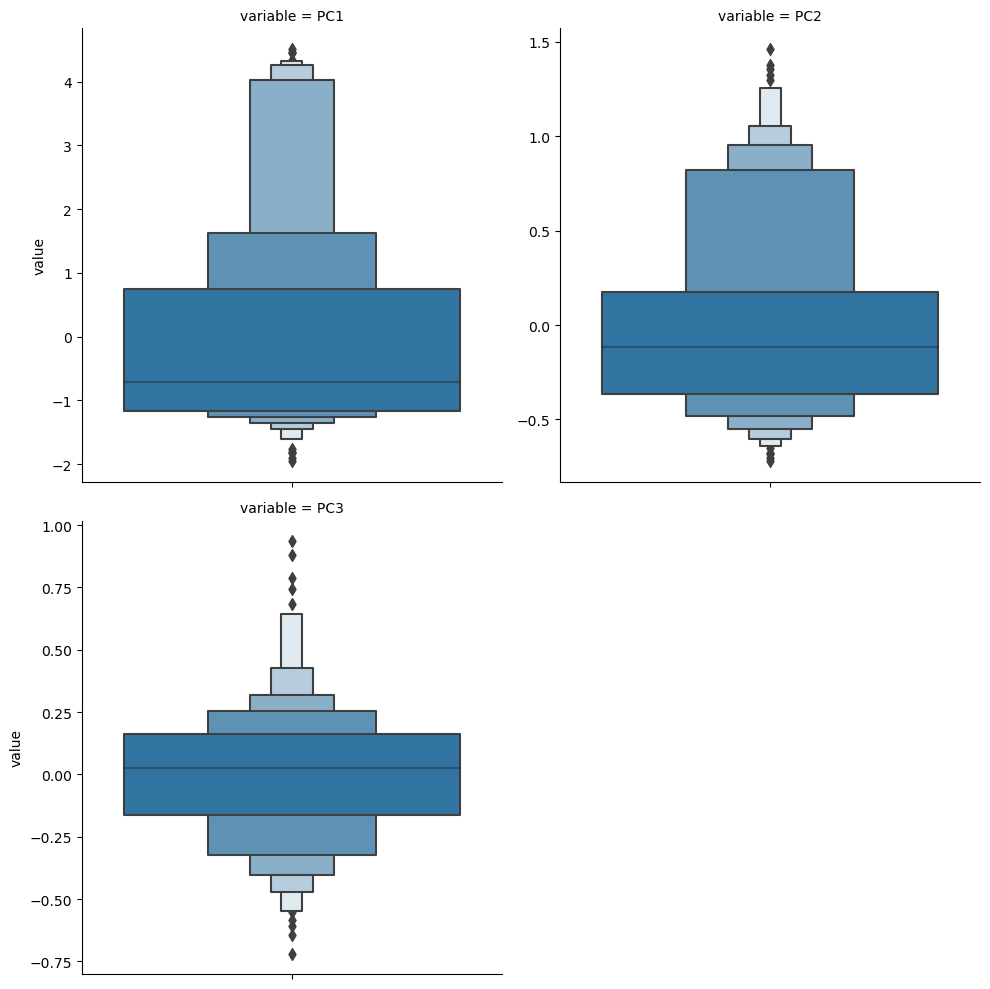

In [14]:
#PCA для поиска выбросов по фичам
import seaborn as sns

sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [16]:
component = "PC3"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["cal"] + features]

,cal,fat,sodium,ash
122,2.59,4.44,0.51,1.54
124,2.58,4.39,0.48,1.52
216,2.61,4.38,0.43,1.41
212,2.56,4.96,0.43,1.42
144,2.85,8.18,0.53,1.63
...,...,...,...,...
74,3.02,21.10,0.43,3.04
68,2.73,16.89,0.25,3.08
114,3.24,25.44,0.60,4.58
86,2.94,20.79,0.37,3.04
